# Analyzing `nakeds`

## 1. Generate Nakeds
### Provide inputs

In [1]:
# * NAKED FUNCTION INPUTS
MARKET = 'SNP'
SYMBOL = 'INTC'
EARLIEST = False
RECALC_UNDS = True
SAVE = False

RUN_ON_PAPER = False

In [2]:
# * IMPORTS
import IPython as ipy
import nest_asyncio
import pathlib

import pandas as pd
from nakeds import get_nakeds
import datetime
from ib_insync import IB
from engine import Vars

import asyncio

# * SETUP

# . current working directory path
cwd = pathlib.Path.cwd()

# . get the host, port, cid
ibp = Vars(MARKET.upper())  # IB Parameters from var.yml
HOST, CID = ibp.HOST, ibp.CID
if RUN_ON_PAPER:
    PORT = ibp.PAPER
else:
    PORT = ibp.PORT

In [3]:
# Specific to Jupyter. Will be ignored in IDE / command-lines

if ipy.get_ipython().__class__.__name__ == 'ZMQInteractiveShell':

    from ib_insync import util
    nest_asyncio.apply()
    util.startLoop()
    pd.options.display.max_columns = None
    pd.options.display.float_format = '{:,.2f}'.format # set float precision with comma
    
    THIS_FOLDER = '' # Dummy for jupyter notebook's current folder
    BAR_FORMAT = "{l_bar}{bar:-20}{r_bar}"

### Get the nakeds and ohlcs

In [4]:
df_nakeds = get_nakeds(MARKET = MARKET,
                        SYMBOL = SYMBOL,
                        EARLIEST = False,
                        RECALC_UNDS = True,
                        SAVE = False)


nakeds started at 10-Dec-2020 17:53:07

dfrqs started at 10-Dec-2020 17:53:08


und:        0%|                         | 0/1 [00:00<?, ?it/s]                  


...dfrqs took: 00:00:06 seconds


snp underlyings started at 10-Dec-2020 17:53:15


price:      0%|                         | 0/60 [00:00<?, ?it/s]                 


...snp underlyings took: 00:00:10 seconds




...nakeds took: 00:00:37 seconds



In [6]:
drop_cols = ['contract', 'secType', 'comm', 
                    'lot', 'close', 'last', 'intrinsic']

df = df_nakeds.drop(drop_cols, 1)

m1 = df.bid>0
m2 = df.ask>0
df[m1&m2].head()
df.head()

,conId,symbol,dte,right,strike,expiry,und_iv,undPrice,und_sd,fallrise,fr_sd,margin,bid,ask,iv,price,sdMult,prop,timevalue,rom,expRom,expPrice,remq,qty
0,458635791,INTC,43,C,57.00,20210122,0.30,49.85,1.41,75.51,5.05,512.65,-1.00,-1.00,0.30,0.64,1.41,0.84,0.64,1.03,2.00,1.24,4,1
1,458947700,INTC,43,C,60.00,20210122,0.30,49.85,2.00,75.51,5.05,383.68,-1.00,-1.00,0.30,0.37,2.00,0.95,0.37,0.78,2.00,0.94,4,1
2,458635470,INTC,29,C,56.00,20210108,0.30,49.85,1.47,74.31,5.86,516.29,-1.00,-1.00,0.30,0.27,1.47,0.86,0.27,0.62,2.00,0.87,4,1
3,455264587,INTC,21,C,55.00,20201231,0.30,49.85,1.45,74.09,6.83,576.76,-1.00,-1.00,0.30,0.22,1.45,0.85,0.22,0.62,2.00,0.72,4,1
4,458635452,INTC,29,C,56.50,20210108,0.30,49.85,1.59,74.31,5.86,481.85,-1.00,-1.00,0.30,0.23,1.59,0.89,0.23,0.56,2.00,0.82,4,1


## 2. Plots
### a) OHLCs from pickle

### b) OHLC - live
#### The function

In [7]:
# .OHLC
async def ohlc(ib: IB,
               c, # contract
               DURATION: int = 365,
               OHLC_DELAY: int = 5) -> pd.DataFrame:

    "Gets OHLC history for stocks / options in UTC date" 

    if isinstance(c, tuple):
        c = c[0]

    if c.secType == 'OPT':
        DUR = "10 D"
        BAR_SIZE = "8 hours"
        WHAT_TO_SHOW = "MIDPOINT"

    else: # for non-options
        DUR = str(DURATION) + " D"
        BAR_SIZE = "1 day"
        WHAT_TO_SHOW = "TRADES"

    ohlc = await ib.reqHistoricalDataAsync(
        contract=c,
        endDateTime=datetime.datetime.now(),
        durationStr=DUR,
        barSizeSetting=BAR_SIZE,
        whatToShow=WHAT_TO_SHOW,
        useRTH=True,
        formatDate=2, # UTC format
    )
    await asyncio.sleep(OHLC_DELAY)
    df = util.df(ohlc)

    # re-cast OHLC for options
    if c.secType == 'OPT':

        # Introduce date without time
        df['dt'] = df['date'].dt.date
        
        # get the grouped values for the option
        g = df.groupby('dt')

        op = g.open.first()
        hi = g.high.max()
        lo = g.low.min()
        cl = g.close.last()
        vol = g.volume.sum()
        avg = g.average.mean()
        bc = g.barCount.sum()        

        df1 = pd.DataFrame({'date': df.dt.unique()})

        df = df1.assign(open=df1['date'].map(op),
                high=df1['date'].map(hi),
                low=df1['date'].map(lo),
                close=df1['date'].map(cl),
                volume=df1['date'].map(vol),
                average=df1['date'].map(avg),
                barCount=df1['date'].map(bc))

        df.insert(0, "localSymbol", c.localSymbol)
        df.insert(1, "strike", c.strike)
        df.insert(2, "right", c.right)
        df.insert(3, "expiry", c.lastTradeDateOrContractMonth)

    df.insert(0, "conId", c.conId)
    df.insert(1, "symbol", c.symbol)
    

    return df

#### Set up the contracts

In [8]:
# . underlying contracts
df_unds = pd.read_pickle(cwd.joinpath('data', MARKET.lower(), 'df_unds.pkl'))
und_ct = df_unds[df_unds.symbol == SYMBOL].contract.iloc[0]

# . option contracts

# ... get some with bid and ask
m1 = df_nakeds.bid>0
m2 = df_nakeds.ask>0

# if bid and ask price are not present (market closed), use last price
if df_nakeds[m1&m2].empty:
    dfo = df_nakeds
else:
    dfo = df_nakeds[m1&m2]


# ... choose the top one
opt_ct = dfo[dfo.conId == dfo.conId.iloc[0]].contract.iloc[0]

In [9]:
%%time
with IB().connect(HOST, PORT, CID )as ib:
    und_ohlcs = ib.run(ohlc(ib, und_ct, 365, 5))
    
with IB().connect(HOST, PORT, CID )as ib:
    opt_ohlcs = ib.run(ohlc(ib, opt_ct))

opt_ohlcs

Wall time: 21.7 s


,conId,symbol,localSymbol,strike,right,expiry,date,open,high,low,close,volume,average,barCount
0,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-03,0.64,1.31,0.53,0.79,-2,-1.00,-2
1,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-04,0.79,1.21,0.65,1.03,-2,-1.00,-2
2,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-07,0.81,1.14,0.41,1.14,-2,-1.00,-2
3,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-08,0.57,0.75,0.57,0.71,-2,-1.00,-2
4,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-09,0.60,0.78,0.58,0.64,-2,-1.00,-2


### Plot the und and option

(<Figure size 720x432 with 1 Axes>,)

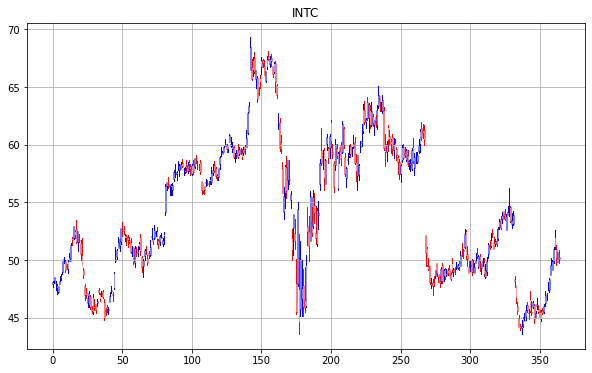

In [10]:
util.barplot(und_ohlcs, title=SYMBOL),

(<Figure size 720x432 with 1 Axes>,)

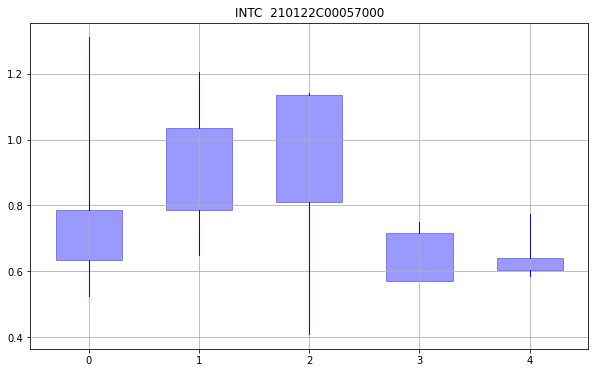

In [11]:
util.barplot(opt_ohlcs, title=opt_ct.localSymbol),

In [12]:
opt_ohlcs.head()

,conId,symbol,localSymbol,strike,right,expiry,date,open,high,low,close,volume,average,barCount
0,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-03,0.64,1.31,0.53,0.79,-2,-1.00,-2
1,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-04,0.79,1.21,0.65,1.03,-2,-1.00,-2
2,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-07,0.81,1.14,0.41,1.14,-2,-1.00,-2
3,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-08,0.57,0.75,0.57,0.71,-2,-1.00,-2
4,458635791,INTC,INTC 210122C00057000,57.00,C,20210122,2020-12-09,0.60,0.78,0.58,0.64,-2,-1.00,-2


### option ohlcs
* Let us play around with option ohlcs

In [17]:
async def opt_ohlc(ib: IB,
                   c, # contract
                   DURATION: str="2 W",
                   OHLC_DELAY: int = 5,
                   BAR_SIZE: str="8 hours",
                   WHAT_TO_SHOW: str="MIDPOINT") -> pd.DataFrame:

    "Gets option OHLC history in UTC date"
    if c.secType == 'OPT':
        DUR = DURATION
        BAR_SIZE = BAR_SIZE
        WHAT_TO_SHOW = WHAT_TO_SHOW

    else:
        print(f'\n{c} is not an option! It is {c.secType}')
        return None
    
    ohlc = await ib.reqHistoricalDataAsync(
        contract=c,
        endDateTime=datetime.datetime.now(),
        durationStr=DUR,
        barSizeSetting=BAR_SIZE,
        whatToShow=WHAT_TO_SHOW,
        useRTH=False,
        formatDate=2, # UTC format
    )
    await asyncio.sleep(OHLC_DELAY)
    df = util.df(ohlc)
    
    return df

In [18]:
%%time
with IB().connect(HOST, PORT, CID )as ib:
    opt_ohlcs1 = ib.run(opt_ohlc(ib, opt_ct, DURATION='2 W', OHLC_DELAY=5,  BAR_SIZE="8 hours", WHAT_TO_SHOW="MIDPOINT"))

opt_ohlcs1

Wall time: 6.09 s


,date,open,high,low,close,volume,average,barCount
0,2020-12-03 14:30:00+00:00,0.64,0.66,0.53,0.62,-1,-1.00,-1
1,2020-12-03 16:00:00+00:00,0.62,1.31,0.60,0.79,-1,-1.00,-1
2,2020-12-04 14:30:00+00:00,0.79,1.07,0.65,1.07,-1,-1.00,-1
3,2020-12-04 16:00:00+00:00,1.07,1.21,0.94,1.03,-1,-1.00,-1
4,2020-12-07 14:30:00+00:00,0.81,0.81,0.54,0.61,-1,-1.00,-1
5,2020-12-07 16:00:00+00:00,0.61,1.14,0.41,1.14,-1,-1.00,-1
6,2020-12-08 14:30:00+00:00,0.57,0.65,0.57,0.64,-1,-1.00,-1
7,2020-12-08 16:00:00+00:00,0.64,0.75,0.62,0.71,-1,-1.00,-1
8,2020-12-09 14:30:00+00:00,0.60,0.74,0.58,0.73,-1,-1.00,-1
9,2020-12-09 16:00:00+00:00,0.73,0.78,0.59,0.64,-1,-1.00,-1


(<Figure size 720x432 with 1 Axes>,)

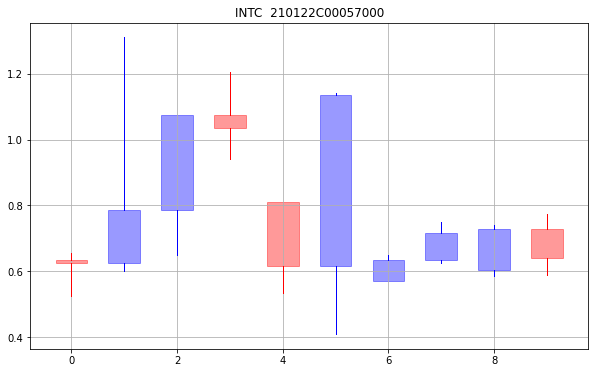

In [19]:
util.barplot(opt_ohlcs1, title=opt_ct.localSymbol),